## Import Library

In [ ]:
import dgl
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import conv as dgl_conv
from startup_data_set import COMP4222Dataset_hetero
from PredictorClasses import *
from CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Hypermeters

In [ ]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 32
output_dim = 16

early_stopping = 5
ep = 800

## Load Dataset

In [ ]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [ ]:
from CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [ ]:
from dgl.nn.pytorch import GraphConv


class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim

        layers = [
            GraphConv(
                self.in_dim,
                self.hidden1_dim,
                activation=F.relu,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
        ]
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)
        self.mean = self.layers[1](g, h)
        self.log_std = self.layers[2](g, h)
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(
            device
        )
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(
            device
        )
        return sampled_z

    def decoder(self, z):
        adj_rec = nn.ReLU()(torch.matmul(z, z.t()))
        return adj_rec

    def forward(self, g, features):
        z = self.encoder(g, features)
        adj_rec = self.decoder(z)
        return adj_rec

In [ ]:
vgae_model = VGAEModel(
    in_feats,
    n_hidden,
    output_dim
)

pred = DotPredictor()

In [ ]:
vgae_model = vgae_model.to(device)
pred = pred.to(device)

In [ ]:
train_g = train_g.to(device)
train_g.ndata['feat'] = train_g.ndata['feat'].float().to(device)
train_pos_g = train_pos_g.to(device)
train_neg_g = train_neg_g.to(device)

### Training Loop

In [ ]:
import itertools
import gc

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(vgae_model.parameters(), pred.parameters()), lr=0.05)

for e in range(ep):
    # forward
    h = vgae_model(train_g, train_g.ndata['feat']).to(device)
    pos_score = pred(train_pos_g, h).to(device)
    neg_score = pred(train_neg_g, h).to(device)
    loss = compute_loss(pos_score, neg_score).to(device)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g.to(device), h.to(device))
    v_neg_score = pred(val_neg_g.to(device), h.to(device))
    v_loss = compute_loss(v_pos_score.to(device), v_neg_score.to(device)).to(device)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 1 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))

    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break

Epoch: 0 	 Train loss: 33123.766 	 Val loss: 33219.457 	 Train AUC: 0.503 	 Val AUC: 0.504
Epoch: 1 	 Train loss: 20347.723 	 Val loss: 20548.342 	 Train AUC: 0.503 	 Val AUC: 0.497
Epoch: 2 	 Train loss: 8098.607 	 Val loss: 8140.381 	 Train AUC: 0.527 	 Val AUC: 0.514
Epoch: 3 	 Train loss: 3566.182 	 Val loss: 3519.181 	 Train AUC: 0.537 	 Val AUC: 0.535
Epoch: 4 	 Train loss: 1930.746 	 Val loss: 1926.229 	 Train AUC: 0.519 	 Val AUC: 0.53
Epoch: 5 	 Train loss: 968.919 	 Val loss: 954.042 	 Train AUC: 0.51 	 Val AUC: 0.538
Epoch: 6 	 Train loss: 626.731 	 Val loss: 630.318 	 Train AUC: 0.505 	 Val AUC: 0.531
Epoch: 7 	 Train loss: 599.521 	 Val loss: 590.305 	 Train AUC: 0.484 	 Val AUC: 0.529
Epoch: 8 	 Train loss: 394.234 	 Val loss: 392.505 	 Train AUC: 0.486 	 Val AUC: 0.53
Epoch: 9 	 Train loss: 296.613 	 Val loss: 288.698 	 Train AUC: 0.466 	 Val AUC: 0.511
Epoch: 10 	 Train loss: 531.264 	 Val loss: 521.627 	 Train AUC: 0.424 	 Val AUC: 0.462
Epoch: 11 	 Train loss: 296.609

In [ ]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.7431267983750023


### Result Plotting

Text(0, 0.5, 'Loss')

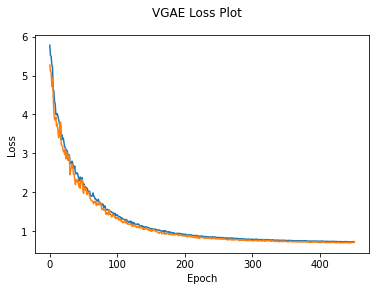

In [ ]:
fig = plt.figure()
plt.plot(train_loss[60:], label='training loss')
plt.plot(val_loss[60:], label = 'validation loss')
fig.suptitle('VGAE Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

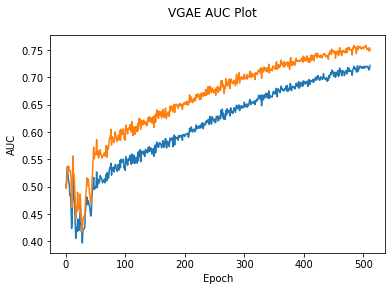

In [ ]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('VGAE AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')